# Potvrzení Heisenbergova principu neurčitosti pomocí difrakce na štěrbině

In [1]:
import cv2, matplotlib.pyplot as plt, numpy as np
from scipy.special import sici
from scipy.optimize import curve_fit

## Step function
Patrně je to distribuční funkce $F(x)$ výskytu "výboj" ve vzdálenosti od středu / dopadu

In [2]:
def Si(x):
    return sici(x)[0]

In [3]:
endPoint = 6
print('Special case of Si(pi)=', Si(np.pi))

Special case of Si(pi)= 1.8519370519824658


$F(x) = \frac{2}{\pi}\left(Si(\pi x) - \frac{2}{\pi}\frac{\sin(\pi \frac{x}{2})^2}{x}\right)$, 

kde $Si(x) = \int_0^x \frac{\sin t}{t} dt $

In [4]:
def original_step_function(x):
    sin_2 = np.power(np.sin(np.pi*x/2), 2)
    _2_pi = 2/np.pi
    return _2_pi*(Si(np.pi*x) - _2_pi*sin_2/x)

In [5]:
def get_x_values(a, range_):
    values = len(a)
    return np.interp(range(values), [0, values-1], range_)

In [6]:
def evaluate_fn(fn, range_, values):
    x_values = get_x_values(range(values), range_)
    y_values = [fn(x) for x in x_values]
    return x_values, y_values

In [7]:
def plot_fn(fn, range_, values):
    return plt.plot(*evaluate_fn(fn, range_, values))

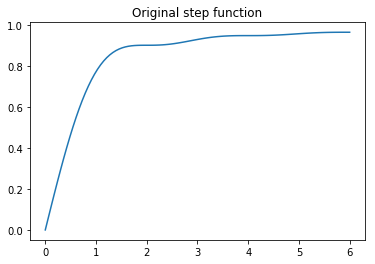

In [8]:
plot_fn(original_step_function, [1e-8, endPoint], 100);
plt.title('Original step function');

## Decoupled function
Tohle už je pravděpodobnost $p(x)$ čehosi, kde $x$ je vzdálenost od středu. Tedy derivace $F(x)$. 

Následující kus kódu je opsán "doslovně". Udělá derivaci $F(x)$ "do středu" a pak $F'(x)$ "od středu". 

In [9]:
# ted opisu doslova tvorbu funcDecouple z C
_,func = evaluate_fn(original_step_function, [1e-8, endPoint], 100)

funcDecouple1 = [0 for _ in range(2*len(func)-1)]
for i in range(len(func),0,-1):
    if i > 1:
        value = func[i-1] - func[i-2]
        funcDecouple1[len(func)+i-2] = value
        funcDecouple1[len(func)-i] = value
    else:
        funcDecouple1[len(func)-1] = funcDecouple1[len(func)]

Vykreslíme funkci v rozsahu $(-z, z)$, kde $0$ je střed a $z$ je `endPoint`. 

In [10]:
def plot_array(a, range_):
    return plt.plot(get_x_values(a, range_), a)

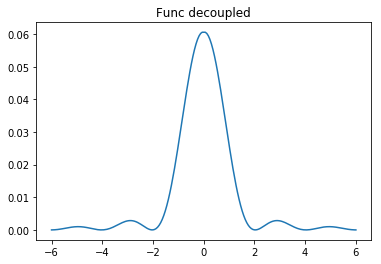

In [11]:
plot_array(funcDecouple1, [-endPoint, endPoint]);
plt.title('Func decoupled');

Nyní kus kódu přepíši pomocí pythonu. 

In [12]:
_,func = evaluate_fn(original_step_function, [1e-8, endPoint], 100)

Nejprve vyrobím derivaci. 

In [13]:
def derivate_a(a):
    return (a - np.roll(a, 1))[1:]

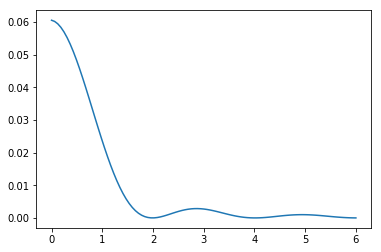

In [14]:
func_d = derivate_a(func)
plot_array(func_d, [1e-8, endPoint]);

Poté spojím obrácenou derivaci a derivaci do jednoho pole. 

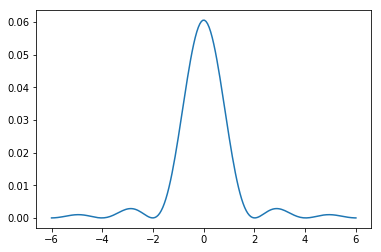

In [15]:
funcDecouple = [x for a in (reversed(func_d), func_d) for x in a]
plot_array(funcDecouple, [-endPoint, endPoint]);

## Zpracování obrazu ze scintilátoru
### Načtení obrazu
Pro načtení obrazu použijeme knihovnu OpenCV. 

rozměry obrazu (600, 800)


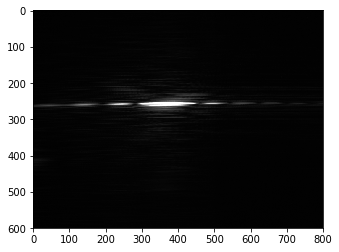

In [16]:
image = cv2.imread('data.png', cv2.IMREAD_GRAYSCALE);
print('rozměry obrazu', image.shape)
plt.imshow(image, cmap='gray');

Obraz sečteme po sloupcích a dostaneme tak intenzitu v x-ové souřadnici. 

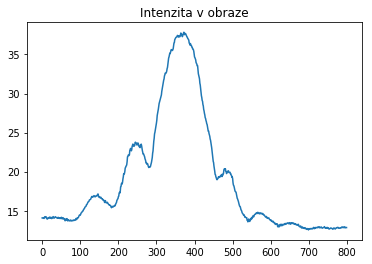

In [17]:
# řádky 46 - 55 v C
h1 = np.sum(image/255, axis = 0)
plt.plot(h1);
plt.title('Intenzita v obraze');

### Hledání maxima v obrazu - NEVYUŽITO
Pro naletení robustnějšího maxima obraz zprůměrujeme klouzavým "průměrem" pomocí konvoluce. 

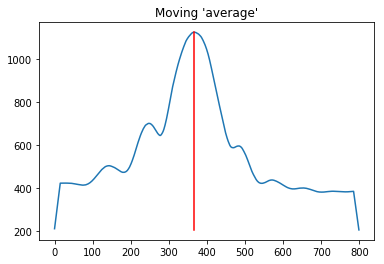

In [18]:
h1_mov_avg = np.convolve(h1, np.ones(30), 'same')
h1_max_x = np.argmax(h1_mov_avg);
plt.plot(h1_mov_avg);
plt.title('Moving \'average\'');
# nakreslim caru v maximu
plt.plot([h1_max_x, h1_max_x], [f(h1_mov_avg) for f in (np.min, np.max)], 'r')

In [19]:
print('Maximum je v x=', h1_max_x)
print('Hodnota maxima je', h1[h1_max_x])
print('Maximální hodnota je', np.max(h1))

Maximum je v x= 367
Hodnota maxima je 37.40784313725519
Maximální hodnota je 37.843137254902224


### Nafitování funkcí na snímek

Máme nafitovat několik funkcí na zachycený snímek. První je: 

$H_{1|ab} (x) = b \left(\frac{\sin(a x)}{a x}\right)^2 $,

kde $a$ a $b$ jsou jakési parametry. Pro $x \in (-z,z)$. 

Druhá funkce je:

$H_{2|abcdef} (x) =  b \left(\frac{\sin(a (x-f))}{a (x-f)}\right)^2
\left(c (x-f)^2+1\right)+d+e(x-f)^2 $

**Pozn:** Do jisté míry tyto funkce připomínají $F'(x)$. Mám podezření, že se použijí k postupnému nafitování parametrů, aby funkce $F'(x)$ seděla na obrázek a fitování neselhalo. 

Pro představu vykreslím funkce s parametry:

| Parameter | Value |
|:-:|----|
| a | 12 |
| b | 3.5 |
| c | 5 |
| d | 0.7 |
| e | 0.01 |
| f | 0 |

In [20]:
def func2_orig(x, a, b):
    return b*(np.sin(a*x)/(a*x))**2

In [21]:
def func2_new(x, a, b, c, d, e, f):
    y = (x - f)**2
    return b*(np.sin(a*(x-f))**2)/(a**2 * y) * (c*y+1) + d + e*y 

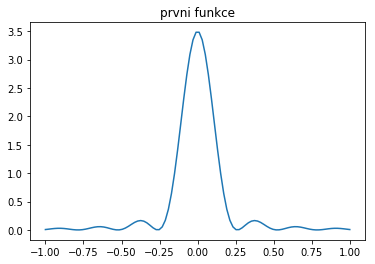

In [22]:
plot_fn(lambda x: func2_orig(x, 12, 3.5), [-1,1], 100);
plt.title('prvni funkce');

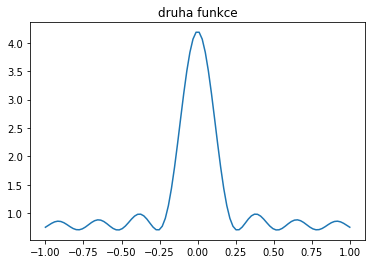

In [23]:
plot_fn(lambda x: func2_new(x, 12, 3.5, 5, 0.7, 0.01, 0), [-1,1], 100);
plt.title('druha funkce');

#### Postup fitování

- Najdeme $g$ tak, že $g\cdot \max_x F'(x) = \max_x I(x)$, kde $I$ je funkce ze snímku.

In [24]:
g = np.max(h1) / np.max(funcDecouple)

- Nalezneme $(a,b)$, aby $H_{1|ab} (x)$ fitovala na $g \cdot F'(x)$.

In [25]:
(a,b),_ = curve_fit(func2_orig, get_x_values(funcDecouple, [-1,1]), np.array(g)*funcDecouple)
print('a,b = ', a, b)

a,b =  -9.375154527359832 37.87145013425044


- Nalezené $(a,b)$ použijeme jako počáteční pro další fitování. 
- Nalezneme $(a,b,c,d,e,f)$, aby $H_{2|abcdef} (x)$ fitovala na $I(x)$.

In [26]:
(a,b,c,d,e,f),_ = curve_fit(func2_new, get_x_values(h1, [-1,1]), h1, p0=[a,b,5,0.7,0.01,0])

In [27]:
for p in 'abcdef': 
    print('{}{:10.3f}'.format(p, vars()[p]))

a    -6.656
b    19.515
c    -5.331
d    17.056
e    -3.950
f    -0.093


**Pozor!!!** Některé parametry vycházejí záporně! Třeba dokonce i $a$, což je zvláštní, když $sinc$ je symetrická. 

**TODO:** Chtělo by to zjistit, v jakém rozmezí se můžou parametry pohybovat a nastavit omezeni pro `curve_fit` parametrem `bounds`. 

**Pozn:** $H_1$ bude fitování na $\frac{\sin x}{x}$ na $F'(x)$ a $H_2$ fituje naměřenou funkci (včetně pozadí). 

#### Vykreslení nafitovaných funkcí

Nafitované parametry $(a,b,c,d,e,f)$ vložíme do následujících funkcí: 

$G_{|abcf} (x) =  b \left(\frac{\sin(a (x-f))}{a (x-f)}\right)^2
\left(c (x-f)^2+1\right) $

a funkce odhadující pozadí: 

$B_{|def} (x) =  d+e(x-f)^2 $

In [28]:
# parametr f=0 a posunu do grafu data
def signal(x):
    return func2_new(x,a,b,c,0,0,f=0)
def background(x):
    # a=1, aby nebylo deleni nulou, b==0 nema vliv
    return func2_new(x,1,0,0,d,e,f=0)

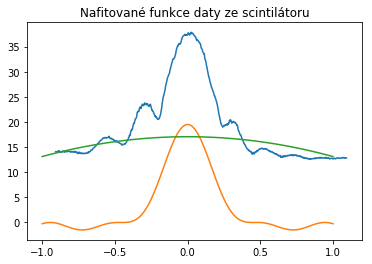

In [29]:
plot_array(h1, [-1-f,1-f]);
plot_fn(signal, [-1,1], 100);
plot_fn(background, [-1,1], 100);
plt.title('Nafitované funkce daty ze scintilátoru');

### Naměřená Step function

Využijeme kumulativní součet jako numerickou integraci pro získání distribuční funkce z naměřených dat. 

**Pozn.:** Integrujeme od středu do krajů, tedy od maxima na levou stranu a posléze na pravou stranu. Maximum bereme z nafitované funkce. 

**Pozn.:** Stejně integrujeme nafitovanou funkci signálu!

In [30]:
def integrate(a):
    return np.cumsum(a)/len(a)

In [31]:
_,signal_y = evaluate_fn(signal, [-1,1], len(h1));
max_x = np.argmax(signal_y)
sI_R = integrate(signal_y[max_x:]) # prava cast
sI_L = integrate(list(reversed(signal_y[:max_x]))) # leva_cast

In [32]:
def plot_signal(sI):
    return plot_array(sI, [0,2*len(sI)/len(signal_y)*endPoint]);

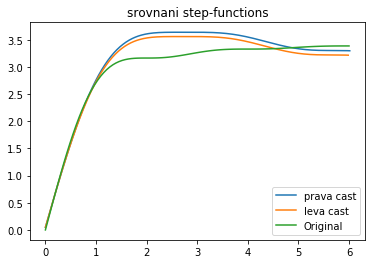

In [33]:
plot_signal(sI_R);
plot_signal(sI_L);
plot_fn(lambda x: original_step_function(x)*b/np.sqrt(np.pi**3) , [1e-8, endPoint], 100);
plt.title('srovnani step-functions');
plt.legend(labels=['prava cast','leva cast','Original']);

**Pozor!!!** Originální step-function je potřeba ještě vhodně přeškálovat. Nebyl jsem sto určit vztah mezi parametry a originální step-function. Můj odhad je $\pi^{-3/2}$. Postup v C nešlo aplikovat, protože aproximace vychází záporná (asi protože $ c < 0 $) a integrál tak klesá. 

## Závěr

Připraveno pro závěr ;-)